# Sample Cluster Analysis

### Objective

Look at the overall data in the samples and determine how different each is in terms of protein clusters found within the samples

In [1]:
BASE = "../data"

import os
import sys
import pandas as pd
from itertools import chain
import shelve
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from collections import Counter
from collections import defaultdict
import operator
from functools import reduce
from itertools import combinations
from matplotlib_venn import *
%matplotlib inline


sys.path.append('..')

from scripts import utils
from scripts.analysis import build_loci
from scripts.analysis.DBInfo import DBInfo

In [2]:
import datetime
def comp_date(date1, date2, cmp):
    return cmp(datetime.datetime.strptime(date1, '%Y-%m-%d'), datetime.datetime.strptime(date2, '%Y-%m-%d'))

## Get metadata and sample info and protein clusters from previously generated files

See README.md in ../data for details on generating these files

In [3]:
db_info = DBInfo("compil_mgm")
metadata = build_loci.read_metadata(os.path.join(BASE,"metadata.csv"))
samples = shelve.open(os.path.join(BASE,"samples.shelve"))
protein_clusters = shelve.open(os.path.join(BASE,"protein_clusters.shelve"))

### Filter out to just Endpoint Unenriced Samples to start (collection date 11-21)

In [4]:
samp_1121 = {s:samples[s] for s in samples if samples[s]['col_date'] == '2015-11-21' and samples[s]['sample_type'] == 'Lysate'}

In [5]:
n14_samp_1121 = {s:samp_1121[s] for s in samp_1121 if not samp_1121[s]['n15']}
n15_samp_1121 = {s:samp_1121[s] for s in samp_1121 if samp_1121[s]['n15']}

In [6]:
clusters_1121 = {}
for s in samp_1121:
    clusters_1121[s] = set(p.cluster_id for p in protein_clusters[s])

## Venn Diagrams to Compare Clusters

Although there are 4 technical Replicates for 11-21 collection date, the first 3 are comared here.  N14 (Colitis) mice are compared first, and then N15 (Healthy) mice

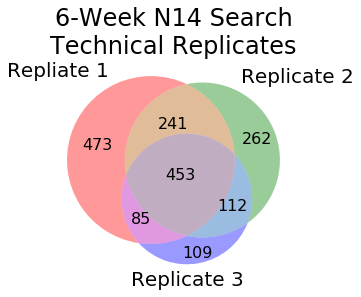

In [7]:
fig = plt.figure()
fig.set_tight_layout(False)
v = venn3([clusters_1121['UL_Mix_1121_1'], clusters_1121['UL_Mix_1121_2'], clusters_1121['UL_Mix_1121_3']],  ("Repliate 1", "Replicate 2", "Replicate 3"))
plt.title("6-Week N14 Search\nTechnical Replicates", size = 24)
for txt in v.set_labels:
    txt.set_fontsize(20)
for text in v.subset_labels:
    text.set_fontsize(16)

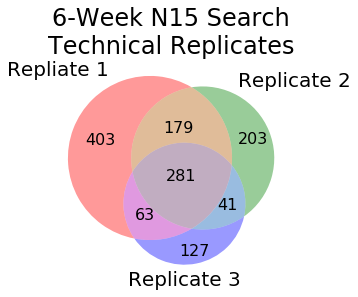

In [8]:
fig = plt.figure()
fig.set_tight_layout(False)
v = venn3([clusters_1121['UL_Mix_1121_N_1'], clusters_1121['UL_Mix_1121_N_2'], clusters_1121['UL_Mix_1121_N_3']],  ("Repliate 1", "Replicate 2", "Replicate 3"))
plt.title("6-Week N15 Search\nTechnical Replicates", size = 24)
for txt in v.set_labels:
    txt.set_fontsize(20)
for text in v.subset_labels:
    text.set_fontsize(16)

### Look at each of the 4 replicates individually

There Appeares to be fewer protein clusters identified in every N15 sample, as opposed to the N14 Samples

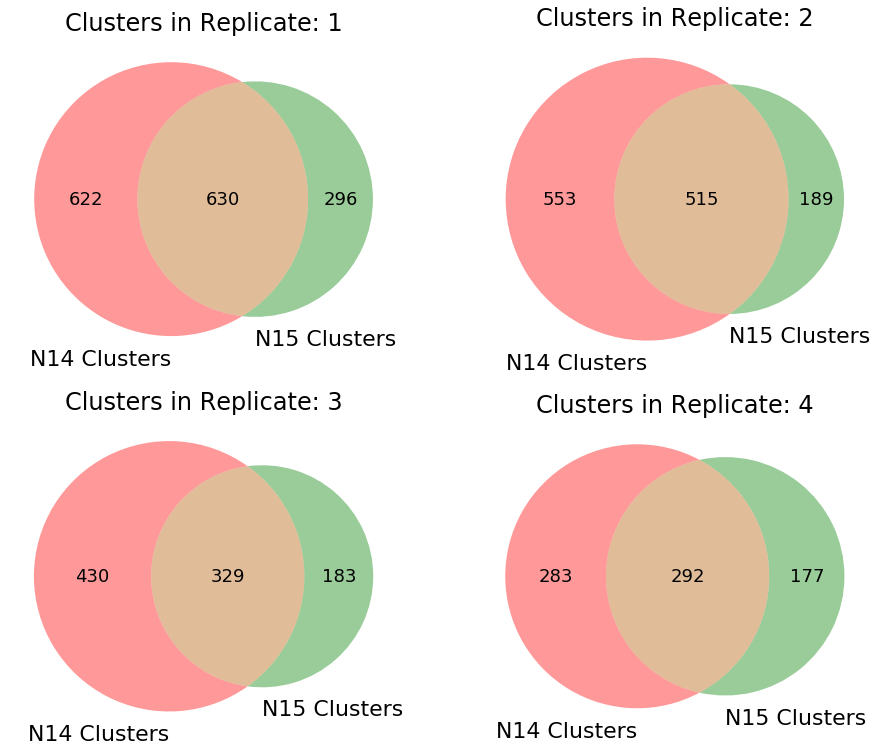

In [9]:
import math
plt.clf()
row = len(n14_samp_1121)//2
fig, ax = plt.subplots(row, 2)
fig.subplots_adjust(left=0, bottom=0, right=2, top=2.5, hspace=.1, wspace = None)
fig.set_tight_layout(False)

for i, s in enumerate(zip(sorted(n14_samp_1121), sorted(n15_samp_1121))):
    n14 = s[0]
    n15 = s[1]
    n14_c = set(p.cluster_id for p in protein_clusters[n14])
    n15_c = set(p.cluster_id for p in protein_clusters[n15])
    v = venn2([n14_c, n15_c], set_labels = ('N14 Clusters', 'N15 Clusters'), ax = ax[int(i/row)][i%row])
    for txt in v.set_labels:
        txt.set_fontsize(22)
    for text in v.subset_labels:
        text.set_fontsize(18)
    ax[int(i/row)][i%row].set_title('Clusters in Replicate: ' + str(samples[s[0]]['technical']), size = 24);
plt.savefig('endpoint-reps.png', dpi = 100);

## Look at the Union of clusters across all technical Replicates

It becsomes even more apparent here that there are fewer N15 protein clusters being identified as opposed to N15 clusers

In [10]:
n14_set = set()
n15_set = set()
for s in clusters_1121:
    if "UL" in s and "_N_" not in s:
        n14_set = n14_set.union(clusters_1121[s])
    if "UL" in s and "_N_" in s:
        n15_set = n15_set.union(clusters_1121[s])

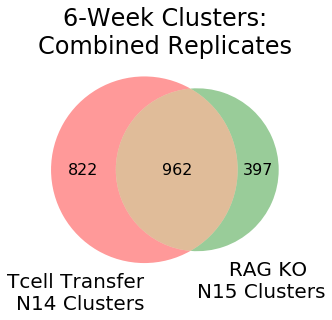

In [11]:
fig = plt.figure()
fig.set_tight_layout(False)
v = venn2([n14_set, n15_set], ("Tcell Transfer\nN14 Clusters", "     RAG KO\nN15 Clusters"))
plt.title("6-Week Clusters:\nCombined Replicates", size = 24)
for txt in v.set_labels:
    txt.set_fontsize(20)
for text in v.subset_labels:
    text.set_fontsize(16)

## Getting an idea for technical reproduciblity

Comaring the different techincal replicates with the same samples with one another to determine how many clusters appear across all

#### Helper functions for this comparison

In [12]:
def union(vals):
    """Given a list of sets, returns their union."""
    return reduce(operator.or_, vals)

def intersection(vals):
    """Given a list of sets, returns their intersection."""
    return reduce(operator.and_, vals)

In [13]:
def info(vals):
    N = len(vals)
    
    res = []
    for i in range(1, N):
        temp = []
        for j, k in zip(combinations(vals, i), reversed(list(combinations(vals, N-i)))):
            temp.append(intersection(j) - union(k))
            
        res.append(union(temp))
        
    return res + [intersection(vals)]

In [14]:
# N14 Cluster Sets
A = clusters_1121['UL_Mix_1121_1']
B = clusters_1121['UL_Mix_1121_2']
C = clusters_1121['UL_Mix_1121_3']
D = clusters_1121['UL_Mix_1121_4']

# N15 Cluster Sets
A1 = clusters_1121['UL_Mix_1121_N_1']
B1 = clusters_1121['UL_Mix_1121_N_2']
C1 = clusters_1121['UL_Mix_1121_N_3']
D1 = clusters_1121['UL_Mix_1121_N_4']

In [15]:
print('N14 Samples - Colitis')
print(len(union([A, B, C, D])), "Total Clusters")
print("% of Clusters\tin # of Samples")
for i, val in enumerate(info([A, B, C, D])):
     print(str(int(len(val) / len(union([A, B, C, D])) * 10000)/100) + '%\t\t\t', i+1)


N14 Samples - Colitis
1784 Total Clusters
% of Clusters	in # of Samples
45.23%			 1
22.75%			 2
13.95%			 3
18.04%			 4


In [16]:
print('N15 Samples - Healthy')
print(len(union([A, B, C, D])), "Total Clusters")
print("% of Clusters\tin # of Samples")
for i, val in enumerate(info([A, B, C, D])):
     print(str(int(len(val) / len(union([A1, B1, C1, D1])) * 10000)/100) + '%\t\t\t', i+1)


N15 Samples - Healthy
1784 Total Clusters
% of Clusters	in # of Samples
59.38%			 1
29.87%			 2
18.32%			 3
23.69%			 4


---


## Similar Reproducitlity analysis for Samples collected 11-11 (4 - weeks on N15 Diet)

In [17]:
samp_1111 = {s:samples[s] for s in samples if samples[s]['col_date'] == '2015-11-11' and not samples[s]['enriched']}

n14_samp_1111 = {s:samp_1111[s] for s in samp_1111 if not samp_1111[s]['n15']}
n15_samp_1111 = {s:samp_1111[s] for s in samp_1111 if samp_1111[s]['n15'] and s.find('_Rg_') < 0}

In [18]:
clusters_1111 = {}
for s in samp_1111:
    clusters_1111[s] = set(p.cluster_id for p in protein_clusters[s])

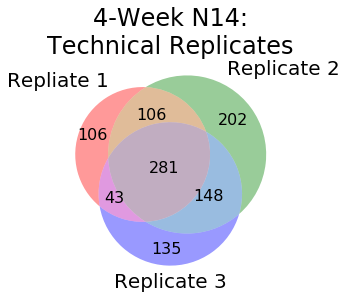

In [19]:
fig = plt.figure()
fig.set_tight_layout(False)
v = venn3([clusters_1111['UL_Mix_1111_1'], clusters_1111["UL_Mix_1111_2"], clusters_1111["UL_Mix_1111_3"]],  ("Repliate 1", "Replicate 2", "Replicate 3"))
plt.title("4-Week N14:\nTechnical Replicates", size = 24)
for txt in v.set_labels:
    txt.set_fontsize(20)
for text in v.subset_labels:
    text.set_fontsize(16)

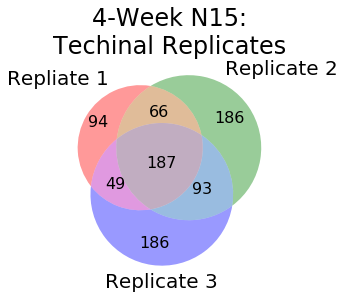

In [20]:
fig = plt.figure()
fig.set_tight_layout(False)
v = venn3([clusters_1111['UL_Mix_1111_N_1'], clusters_1111['UL_Mix_1111_N_2'], clusters_1111['UL_Mix_1111_N_3']],  ("Repliate 1", "Replicate 2", "Replicate 3"))
plt.title("4-Week N15:\nTechinal Replicates", size = 24)
for txt in v.set_labels:
    txt.set_fontsize(20)
for text in v.subset_labels:
    text.set_fontsize(16)

In [21]:
for s in sorted(n14_samp_1111):
    print(s,':', len(set(p.cluster_id for p in protein_clusters[s])))

UL_Mix_1111_1 : 536
UL_Mix_1111_2 : 737
UL_Mix_1111_3 : 607


In [22]:
for s in sorted(n15_samp_1111):
    print(s, ':', len(set(p.cluster_id for p in protein_clusters[s])))

UL_Mix_1111_N_1 : 396
UL_Mix_1111_N_2 : 532
UL_Mix_1111_N_3 : 515


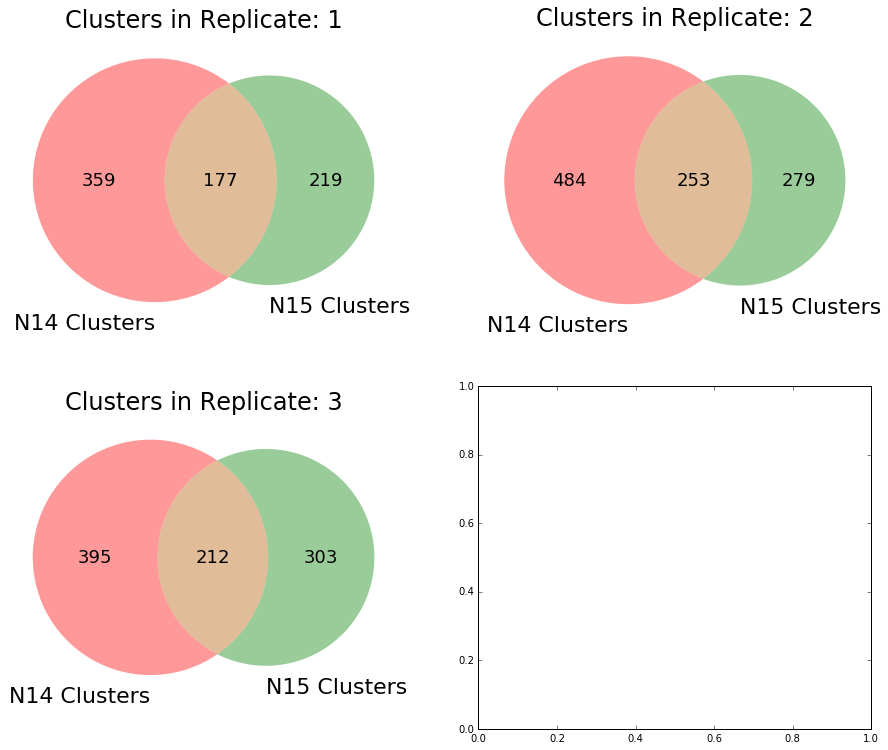

In [23]:
plt.clf()
num_samps = len(n14_samp_1111)
if num_samps%2 == 0:
    row = num_samps//2
else:
    row = (num_samps//2)+1
fig, ax = plt.subplots(row, 2)

fig.subplots_adjust(left=0, bottom=0, right=2, top=2.5, hspace=.1, wspace = None)
fig.set_tight_layout(False)

for i, s in enumerate(zip(sorted(n14_samp_1111), sorted(n15_samp_1111))):
    n14 = s[0]
    n15 = s[1]
    n14_c = set(p.cluster_id for p in protein_clusters[n14])
    n15_c = set(p.cluster_id for p in protein_clusters[n15])
    
    v = venn2([n14_c, n15_c], set_labels = ('N14 Clusters', 'N15 Clusters'), ax = ax[int(i/row)][i%row])
    for txt in v.set_labels:
        txt.set_fontsize(22)
    for text in v.subset_labels:
        text.set_fontsize(18)
    ax[int(i/row)][i%row].set_title('Clusters in Replicate: ' + str(samples[s[0]]['technical']), size = 24)
plt.savefig('4-week-reps.png', dpi = 100);

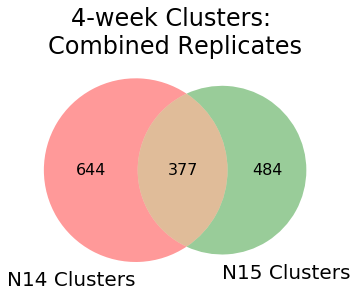

In [24]:
fig = plt.figure()
fig.set_tight_layout(False)
v = venn2([set.union(clusters_1111['UL_Mix_1111_1'],clusters_1111["UL_Mix_1111_2"], clusters_1111["UL_Mix_1111_3"]), set.union(clusters_1111['UL_Mix_1111_N_1'],clusters_1111["UL_Mix_1111_N_2"], clusters_1111["UL_Mix_1111_N_3"])], ("N14 Clusters", "N15 Clusters"))
plt.title("4-week Clusters: \nCombined Replicates", size = 24)
for txt in v.set_labels:
    txt.set_fontsize(20)
for text in v.subset_labels:
    text.set_fontsize(16)

---

## Checking Reproducibility across all searches

#### First get a list containing a set of protein clusters for each search

In [25]:
unenriched_n14 = []
unenriched_n15 = []

for s in tqdm(samples):
    if not samples[s]['n15'] and not samples[s]['enriched'] and samples[s]['sample_type'] == 'Lysate':
        unenriched_n14.append(set(p.cluster_id for p in protein_clusters[s]))
    if samples[s]['n15'] and not samples[s]['enriched'] and samples[s]['sample_type'] == 'Lysate':
        unenriched_n15.append(set(p.cluster_id for p in protein_clusters[s]))

100%|██████████| 52/52 [01:05<00:00,  1.02it/s]


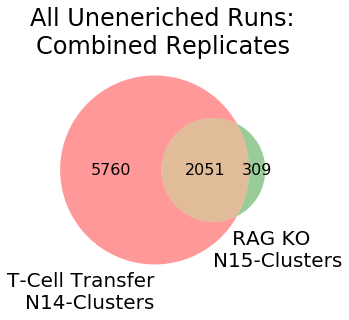

In [26]:
fig = plt.figure()
fig.set_tight_layout(False)
v = venn2([union(unenriched_n14), union(unenriched_n15)], ("T-Cell Transfer\nN14-Clusters", "   RAG KO\nN15-Clusters"))
plt.title("All Uneneriched Runs:\nCombined Replicates", size = 24)
for txt in v.set_labels:
    txt.set_fontsize(20)
for text in v.subset_labels:
    text.set_fontsize(16)

### Helper functions determine the overlap between each cluster

In [27]:
print(len(union(unenriched_n14)), 'Unique Protein Clusters in n14 (colitis) Searches')
print("% of Clusters\tin # of Samples")
for i, val in enumerate(info(unenriched_n14)):
     print(str(int(len(val) / len(union(unenriched_n14)) * 10000)/100) + '%\t\t\t', i+1)


7811 Unique Protein Clusters in n14 (colitis) Searches
% of Clusters	in # of Samples
35.41%			 1
19.75%			 2
12.7%			 3
8.89%			 4
6.08%			 5
3.59%			 6
3.02%			 7
2.48%			 8
2.11%			 9
1.29%			 10
1.52%			 11
0.9%			 12
0.78%			 13
1.43%			 14


In [28]:
print(len(union(unenriched_n15)), 'Unique Protein Clusters in N15 (healthy) Searches')
print("% of Clusters\tin # of Samples")
for i, val in enumerate(info(unenriched_n15)):
     print(str(int(len(val) / len(union(unenriched_n15)) * 10000)/100) + '%\t\t\t', i+1)


2360 Unique Protein Clusters in N15 (healthy) Searches
% of Clusters	in # of Samples
43.47%			 1
16.61%			 2
9.53%			 3
6.48%			 4
3.26%			 5
3.64%			 6
2.71%			 7
2.07%			 8
2.75%			 9
2.2%			 10
2.24%			 11
1.35%			 12
1.05%			 13
1.18%			 14
0.5%			 15
0.42%			 16
0.46%			 17


---

## Comparison of clusters in samples as time on N15 Increases

Now we will look at how the clusters compare between the N14 and N15 mice as the length of time they are on the labeled diet increases

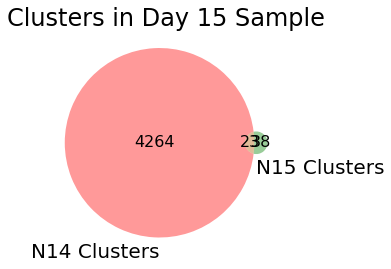

In [29]:
n14 = 'UL_Mix_1016_1'
n15 = 'UL_Mix_1016_N_1'

n14_c = set(p.cluster_id for p in protein_clusters[n14])
n15_c = set(p.cluster_id for p in protein_clusters[n15])

fig = plt.figure()
fig.set_tight_layout(False)
v = venn2([n14_c, n15_c], ['N14 Clusters', 'N15 Clusters'])
for txt in v.set_labels:
    txt.set_fontsize(20)
for text in v.subset_labels:
    text.set_fontsize(16)
plt.title("Clusters in Day 15 Sample", size = 24);

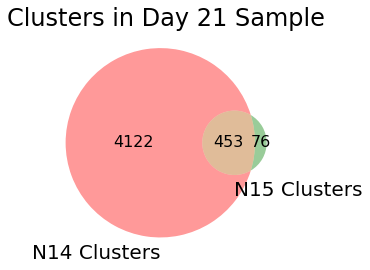

In [30]:
n14 = 'UL_Mix_1021_1'
n15 = 'UL_Mix_1021_N_1'

n14_c = set(p.cluster_id for p in protein_clusters[n14])
n15_c = set(p.cluster_id for p in protein_clusters[n15])

fig = plt.figure()
fig.set_tight_layout(False)
v = venn2([n14_c, n15_c], ['N14 Clusters', 'N15 Clusters'])
for txt in v.set_labels:
    txt.set_fontsize(20)
for text in v.subset_labels:
    text.set_fontsize(16)
plt.title("Clusters in Day 21 Sample", size = 24)

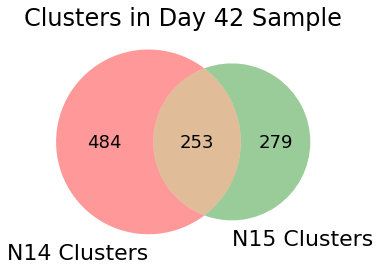

In [31]:
n14 = 'UL_Mix_1111_2'
n15 = 'UL_Mix_1111_N_2'

n14_c = set(p.cluster_id for p in protein_clusters[n14])
n15_c = set(p.cluster_id for p in protein_clusters[n15])

fig = plt.figure()
fig.set_tight_layout(False)
v = venn2([n14_c, n15_c], ['N14 Clusters', 'N15 Clusters'])
for txt in v.set_labels:
    txt.set_fontsize(22)
for text in v.subset_labels:
    text.set_fontsize(18)
plt.title("Clusters in Day 42 Sample", size = 24);

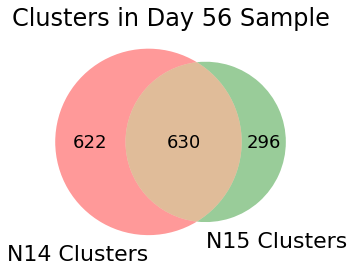

In [32]:
n14 = 'UL_Mix_1121_1'
n15 = 'UL_Mix_1121_N_1'

n14_c = set(p.cluster_id for p in protein_clusters[n14])
n15_c = set(p.cluster_id for p in protein_clusters[n15])

fig = plt.figure()
fig.set_tight_layout(False)
v = venn2([n14_c, n15_c], ['N14 Clusters', 'N15 Clusters'])
for txt in v.set_labels:
    txt.set_fontsize(22)
for text in v.subset_labels:
    text.set_fontsize(18)
plt.title("Clusters in Day 56 Sample", size = 24);

---

# Now to examine the Pooled Samples data

## Look at the differences in clusters in the Unenriched Enriched Replicate 1

First start with run #1 of the Unenriched Samples

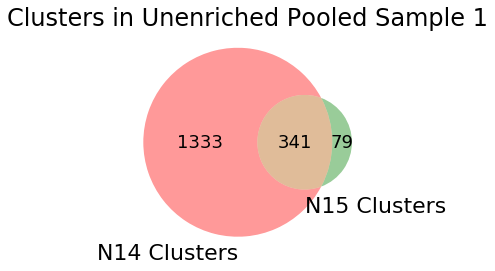

In [33]:
n14 = 'UL_Mix_Pool_1'
n15 = 'UL_Mix_Pool_N_1'

n14_c = set(p.cluster_id for p in protein_clusters[n14])
n15_c = set(p.cluster_id for p in protein_clusters[n15])

fig = plt.figure()
fig.set_tight_layout(False)
v = venn2([n14_c, n15_c], ['N14 Clusters', 'N15 Clusters'])
for txt in v.set_labels:
    txt.set_fontsize(22)
for text in v.subset_labels:
    text.set_fontsize(18)
plt.title("Clusters in Unenriched Pooled Sample 1", size = 24);

## Look at the differences in clusters in the BioGlyCMK Enriched Samples

First start with run #1 and remove any clusters found in DMSO control runs

1517 208
204


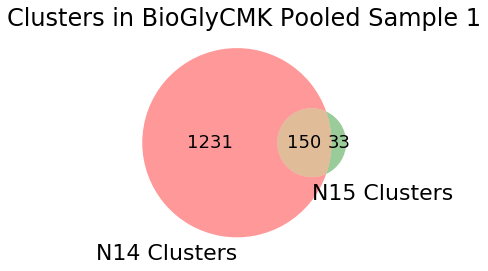

In [34]:
n14 = 'CL_Mix_Pool_1'
n15 = 'CL_Mix_Pool_N_1'

n14_c = set(p.cluster_id for p in protein_clusters[n14])
n15_c = set(p.cluster_id for p in protein_clusters[n15])

print(len(n14_c), len(n15_c))

ctl_c1 = set(p.cluster_id for p in protein_clusters['DL_Mix_Pool_1'])
ctl_c2 = set(p.cluster_id for p in protein_clusters['DL_Mix_Pool_N_1'])

ctl_c = set.union(ctl_c1, ctl_c2)
print(len(ctl_c))

n14_c = n14_c - ctl_c
n15_c = n15_c - ctl_c

fig = plt.figure()
fig.set_tight_layout(False)
v = venn2([n14_c, n15_c], ['N14 Clusters', 'N15 Clusters'])
for txt in v.set_labels:
    txt.set_fontsize(22)
for text in v.subset_labels:
    text.set_fontsize(18)
plt.title("Clusters in BioGlyCMK Pooled Sample 1", size = 24);